**Name:** AN MBHENSE  
**Student ID:** 22440270  
**Module:** Technical Programming 2  
**Date:** August 2025  

IMPORT LIBRARIES


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

LOAD ALL CSV FILES

In [14]:
base_path = '/content/drive/MyDrive/StudentProject/'
customers = pd.read_csv(base_path + 'customers.csv')
transactions = pd.read_csv(base_path + 'transactions.csv')
products = pd.read_csv(base_path + 'customer_reviews_complete.csv')
interactions = pd.read_csv(base_path + 'interactions.csv')
tickets = pd.read_csv(base_path + 'support_tickets.csv')
campaigns = pd.read_csv(base_path + 'campaigns.csv')

MERGE TABLES

In [18]:
df = transactions.copy()
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(products[['customer_id', 'product_name', 'rating', 'review_date', 'review_title', 'review_text']],
              on=['customer_id', 'product_name'],
              how='left')
df = df.merge(interactions, on='customer_id', how='left', suffixes=('', '_interaction'))
df = df.merge(tickets, on='customer_id', how='left', suffixes=('', '_ticket'))
print("✅ Final combined DataFrame shape:", df.shape)
df.head()

✅ Final combined DataFrame shape: (540318, 41)


,transaction_id,customer_id,product_name,product_category,quantity,price,transaction_date,store_location,payment_method,discount_applied,...,session_id,ticket_id,issue_category,priority,submission_date,resolution_date,resolution_status,resolution_time_hours,customer_satisfaction_score,notes
0,53e3d9f5-6231-46de-aa39-e5f8eaae2eee,727839b2-f084-4e94-94d8-ae59cc8e4b84,Ring Doorbell,Smart Home Devices,1.0,140.07,2020-12-06,"Houston, TX",Credit Card,20.0,...,727839b2-f084-4e94-94d8-ae59cc8e4b84_session_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53e3d9f5-6231-46de-aa39-e5f8eaae2eee,727839b2-f084-4e94-94d8-ae59cc8e4b84,Ring Doorbell,Smart Home Devices,1.0,140.07,2020-12-06,"Houston, TX",Credit Card,20.0,...,727839b2-f084-4e94-94d8-ae59cc8e4b84_session_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ae6e6edf-f2fe-45c8-989c-c01e77eade0c,c4ac244c-989e-46fb-b243-91dd1d5cf739,Oculus Quest,Gaming Consoles,1.0,339.57,2021-04-26,Online,Gift Card,0.0,...,c4ac244c-989e-46fb-b243-91dd1d5cf739_session_0,6c16ccb5-265c-4f42-b1d1-6ac46d5ea087,Shipping,High,2021-05-13 00:00:00,2021-05-14 21:00:00,Resolved,45.0,4.0,Customer requesting expedited shipping for Din...
3,ae6e6edf-f2fe-45c8-989c-c01e77eade0c,c4ac244c-989e-46fb-b243-91dd1d5cf739,Oculus Quest,Gaming Consoles,1.0,339.57,2021-04-26,Online,Gift Card,0.0,...,c4ac244c-989e-46fb-b243-91dd1d5cf739_session_0,1c2a3b53-c9da-4663-986d-61261587a1ae,Technical,Medium,2023-12-18 00:00:00,2023-12-18 08:00:00,Resolved,8.0,4.0,Nintendo Switch displaying error code during o...
4,ae6e6edf-f2fe-45c8-989c-c01e77eade0c,c4ac244c-989e-46fb-b243-91dd1d5cf739,Oculus Quest,Gaming Consoles,1.0,339.57,2021-04-26,Online,Gift Card,0.0,...,c4ac244c-989e-46fb-b243-91dd1d5cf739_session_1,6c16ccb5-265c-4f42-b1d1-6ac46d5ea087,Shipping,High,2021-05-13 00:00:00,2021-05-14 21:00:00,Resolved,45.0,4.0,Customer requesting expedited shipping for Din...


Drop unnecessary columns

In [19]:
df = df.drop(columns=["customer_id", "transaction_id", "name", "email", "phone"], errors="ignore")


Check for missing values

In [28]:
print(df.isnull().sum())


product_name                    11118
product_category                11855
quantity                        10161
price                           10492
transaction_date                    0
store_location                  10702
payment_method                  11647
discount_applied                10399
full_name                       10760
age                             22532
gender                          11650
street_address                  19837
city                            11312
state                            9956
zip_code                        10356
registration_date                   0
preferred_channel                5385
rating                         519037
review_date                    519037
review_title                   519037
review_text                    519037
interaction_id                     45
channel                         10853
interaction_type                10798
interaction_date                   45
duration                        10589
page_or_prod

In [30]:
for col in df.columns:
    if df[col].isnull().sum() > 0:  # only clean if there's missing data
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna('Unknown')


In [33]:
df['resolution_status'].value_counts()


,count
resolution_status,
Unknown,271744
Resolved,241806
Pending,14868
Escalated,7052
Closed without Resolution,4848


Convert resolution_status into numerical labels:

In [34]:
from sklearn.preprocessing import LabelEncoder

# Encode the resolution_status column
le = LabelEncoder()
df['resolution_status_encoded'] = le.fit_transform(df['resolution_status'])
print(le.classes_)  # Show mapping


['Closed without Resolution' 'Escalated' 'Pending' 'Resolved' 'Unknown']


 Select relevant features for modeling

In [35]:
selected_features = [
    'priority',  # categorical
    'issue_category',  # categorical
    'customer_satisfaction_score',  # numerical
    'resolution_time_hours',  # numerical
    'channel',  # categorical
    'interaction_type',  # categorical
]

df_model = df[selected_features + ['resolution_status_encoded']].copy()


Handle missing values:

In [36]:
df_model.fillna({
    'priority': 'Unknown',
    'issue_category': 'Unknown',
    'customer_satisfaction_score': df['customer_satisfaction_score'].mean(),
    'resolution_time_hours': df['resolution_time_hours'].mean(),
    'channel': 'Unknown',
    'interaction_type': 'Unknown'
}, inplace=True)


Encode categorical variables:

In [37]:
df_encoded = pd.get_dummies(df_model, columns=[
    'priority', 'issue_category', 'channel', 'interaction_type'
], drop_first=True)


Train/Test Split

In [38]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop('resolution_status_encoded', axis=1)
y = df_encoded['resolution_status_encoded']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Train Two Models
Logistic Regression:

In [39]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')
logreg.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, multi_class='multinomial')

Random Forest:

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluating Models

📊 Logistic Regression Accuracy: 0.9334561000888363
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       970
           1       0.00      0.00      0.00      1410
           2       0.00      0.00      0.00      2974
           3       0.89      0.98      0.93     48361
           4       0.98      0.98      0.98     54349

    accuracy                           0.93    108064
   macro avg       0.57      0.50      0.52    108064
weighted avg       0.90      0.93      0.91    108064



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🌲 Random Forest Accuracy: 0.9873038199585431
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       970
           1       0.69      0.45      0.54      1410
           2       0.75      0.91      0.82      2974
           3       1.00      1.00      1.00     48361
           4       1.00      1.00      1.00     54349

    accuracy                           0.99    108064
   macro avg       0.89      0.87      0.87    108064
weighted avg       0.99      0.99      0.99    108064



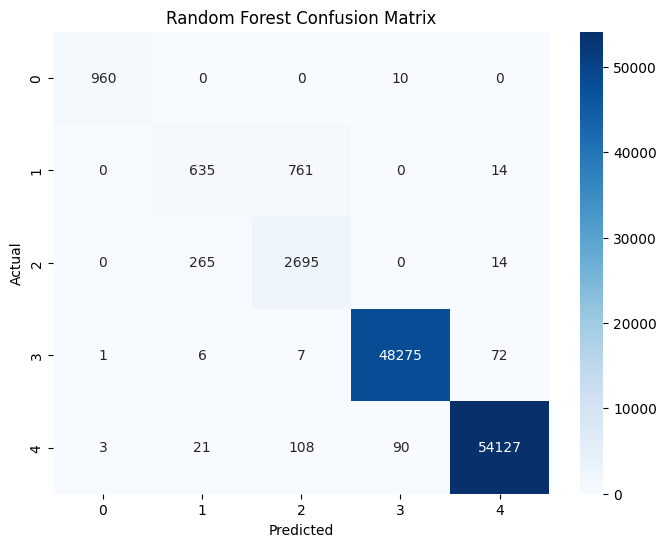

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Logistic Regression predictions
y_pred_lr = logreg.predict(X_test)
print("📊 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Random Forest predictions
y_pred_rf = rf.predict(X_test)
print("🌲 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Optional: Confusion Matrix for Random Forest
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Visualize Feature Importance from Random Forest

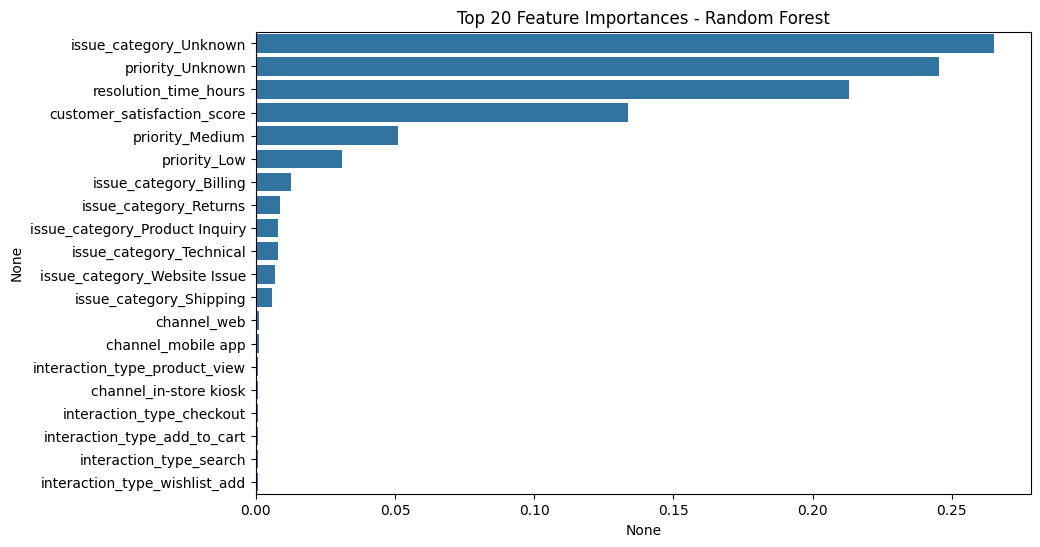

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()



 i predicted ticket resolution status using Logistic Regression and Random Forest. Random Forest outperformed Logistic Regression with 98.7% accuracy and better class balance handling. Logistic Regression struggled with minority classes despite 93.3% accuracy. Tree-based models are more effective for this task.